# 📊 Análises de Dados Governamentais - GovBR

Este notebook contém análises exploratórias dos dados coletados das APIs governamentais:
- Portal da Transparência (Bolsa Família, BPC)
- IBGE (Municípios, Estados, População)

## Estrutura das Camadas:
- **Bronze**: Dados brutos coletados das APIs
- **Prata**: Dados transformados e relacionados
- **Ouro**: Dados enriquecidos com análises e métricas

In [1]:
# Configurações e imports
import pandas as pd
import numpy as np
from minio import Minio
import io
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configurações MinIO
MINIO_SERVER_URL = "ch8ai-minio.l6zv5a.easypanel.host"
MINIO_ROOT_USER = "admin"
MINIO_ROOT_PASSWORD = "1q2w3e4r"
BUCKET_NAME = "govbr"

# Cliente MinIO
minio_client = Minio(
    MINIO_SERVER_URL,
    access_key=MINIO_ROOT_USER,
    secret_key=MINIO_ROOT_PASSWORD,
    secure=True
)

print("✅ Configurações carregadas!")

✅ Configurações carregadas!


In [2]:
def read_from_storage(camada, dataset_name, partition_date=None):
    """Lê DataFrame de qualquer camada (bronze, prata, ouro)"""
    if partition_date is None:
        # Buscar a partição mais recente
        prefix = f"{camada}/{dataset_name}/"
        objects = list(minio_client.list_objects(BUCKET_NAME, prefix=prefix, recursive=True))
        if not objects:
            return None
        
        # Pegar o mais recente
        latest = max(objects, key=lambda x: x.last_modified)
        object_name = latest.object_name
    else:
        object_name = f"{camada}/{dataset_name}/dt={partition_date}/data.parquet"
    
    try:
        response = minio_client.get_object(BUCKET_NAME, object_name)
        df = pd.read_parquet(io.BytesIO(response.read()))
        response.close()
        response.release_conn()
        print(f"✅ Lido: {object_name} ({len(df)} registros)")
        return df
    except Exception as e:
        print(f"❌ Erro ao ler {object_name}: {e}")
        return None

print("✅ Função de leitura criada!")

✅ Função de leitura criada!


## 1. Carregando Dados da Camada Ouro (Dados Enriquecidos)

In [3]:
# Carregar dados da camada Ouro
print("Carregando dados da camada Ouro...\n")

municipios_ouro = read_from_storage('ouro', 'municipios_enriquecidos')
estados_ouro = read_from_storage('ouro', 'estados_enriquecidos')
bolsa_familia_ouro = read_from_storage('ouro', 'bpc_analytics')  # Pode conter ambos BPC e Bolsa Família
rankings = read_from_storage('ouro', 'rankings')
resumo_geral = read_from_storage('ouro', 'resumo_geral')

print("\n✅ Dados carregados!")

Carregando dados da camada Ouro...

✅ Lido: ouro/municipios_enriquecidos/dt=20251115/data.parquet (5571 registros)
✅ Lido: ouro/estados_enriquecidos/dt=20251115/data.parquet (27 registros)
✅ Lido: ouro/bpc_analytics/dt=20251115/data.parquet (550 registros)
✅ Lido: ouro/rankings/dt=20251115/data.parquet (40 registros)
✅ Lido: ouro/resumo_geral/dt=20251115/data.parquet (4 registros)

✅ Dados carregados!


## 2. Carregando Dados da Camada Prata (Dados Transformados)

In [4]:
# Carregar dados da camada Prata para análises detalhadas
print("Carregando dados da camada Prata...\n")

fato_bolsa_familia = read_from_storage('prata', 'fato_bolsa_familia')
fato_bpc = read_from_storage('prata', 'fato_bpc')
dim_municipios = read_from_storage('prata', 'dim_municipios')
dim_estados = read_from_storage('prata', 'dim_estados')

print("\n✅ Dados da Prata carregados!")

Carregando dados da camada Prata...

✅ Lido: prata/fato_bolsa_familia/dt=20251115/data.parquet (500 registros)
✅ Lido: prata/fato_bpc/dt=20251115/data.parquet (50 registros)
✅ Lido: prata/dim_municipios/dt=20251115/data.parquet (5571 registros)
✅ Lido: prata/dim_estados/dt=20251115/data.parquet (27 registros)

✅ Dados da Prata carregados!


## 3. Resumo Geral dos Dados

In [5]:
if resumo_geral is not None:
    print("📊 RESUMO GERAL:")
    print(resumo_geral.to_string(index=False))
else:
    print("📊 RESUMO DOS DADOS CARREGADOS:")
    print(f"\n✅ Municípios: {len(municipios_ouro) if municipios_ouro is not None else 0}")
    print(f"✅ Estados: {len(estados_ouro) if estados_ouro is not None else 0}")
    print(f"✅ Bolsa Família: {len(fato_bolsa_familia) if fato_bolsa_familia is not None else 0} registros")
    print(f"✅ BPC: {len(fato_bpc) if fato_bpc is not None else 0} registros")

📊 RESUMO GERAL:
            metrica         valor_texto  valor_numerico
   Total Municípios                5571          5571.0
      Total Estados                  27            27.0
Total Registros BPC                  50            50.0
 Data Processamento 2025-11-15 20:48:06             NaN


## 4. Análise de Bolsa Família

In [6]:
if fato_bolsa_familia is not None and len(fato_bolsa_familia) > 0:
    print("📊 ESTATÍSTICAS DESCRITIVAS - BOLSA FAMÍLIA")
    print("=" * 80)
    
    # Estatísticas básicas
    print("\n💰 Valores Totais:")
    print(f"  Total investido: R$ {fato_bolsa_familia['valor_total'].sum():,.2f}")
    print(f"  Média por município: R$ {fato_bolsa_familia['valor_total'].mean():,.2f}")
    print(f"  Mediana: R$ {fato_bolsa_familia['valor_total'].median():,.2f}")
    print(f"  Máximo: R$ {fato_bolsa_familia['valor_total'].max():,.2f}")
    print(f"  Mínimo: R$ {fato_bolsa_familia['valor_total'].min():,.2f}")
    
    print("\n👥 Beneficiários:")
    print(f"  Total de beneficiários: {fato_bolsa_familia['quantidade_beneficiarios'].sum():,.0f}")
    print(f"  Média por município: {fato_bolsa_familia['quantidade_beneficiarios'].mean():,.0f}")
    print(f"  Máximo: {fato_bolsa_familia['quantidade_beneficiarios'].max():,.0f}")
    
    if 'percentual_beneficiarios' in fato_bolsa_familia.columns:
        print("\n📈 Percentual de Beneficiários:")
        print(f"  Média: {fato_bolsa_familia['percentual_beneficiarios'].mean():.2f}%")
        print(f"  Máximo: {fato_bolsa_familia['percentual_beneficiarios'].max():.2f}%")
    
    if 'valor_medio_beneficiario' in fato_bolsa_familia.columns:
        print("\n💵 Valor Médio por Beneficiário:")
        print(f"  Média: R$ {fato_bolsa_familia['valor_medio_beneficiario'].mean():.2f}")
        print(f"  Mediana: R$ {fato_bolsa_familia['valor_medio_beneficiario'].median():.2f}")
    
    print("\n🌎 Distribuição por UF:")
    if 'uf_sigla' in fato_bolsa_familia.columns:
        uf_stats = fato_bolsa_familia.groupby('uf_sigla').agg({
            'valor_total': 'sum',
            'quantidade_beneficiarios': 'sum',
            'nome_municipio': 'count'
        }).rename(columns={'nome_municipio': 'num_municipios'})
        uf_stats = uf_stats.sort_values('valor_total', ascending=False)
        print(uf_stats.to_string())
else:
    print("⚠️ Dados de Bolsa Família não disponíveis")

📊 ESTATÍSTICAS DESCRITIVAS - BOLSA FAMÍLIA

💰 Valores Totais:
  Total investido: R$ 412,525,161.00
  Média por município: R$ 825,050.32
  Mediana: R$ 468,107.50
  Máximo: R$ 20,073,916.00
  Mínimo: R$ 18,481.00

👥 Beneficiários:
  Total de beneficiários: 1,992,622
  Média por município: 3,985
  Máximo: 131,126

📈 Percentual de Beneficiários:
  Média: 16.36%
  Máximo: 202.16%

💵 Valor Médio por Beneficiário:
  Média: R$ 211.90
  Mediana: R$ 200.78

🌎 Distribuição por UF:
          valor_total  quantidade_beneficiarios  num_municipios
uf_sigla                                                       
PA        190150733.0                    960554             144
AM         91310101.0                    404493              62
MA         43823703.0                    205246              50
AC         24353549.0                     90525              22
TO         22474279.0                    121212             139
AP         17140495.0                     75597              16
RO         12

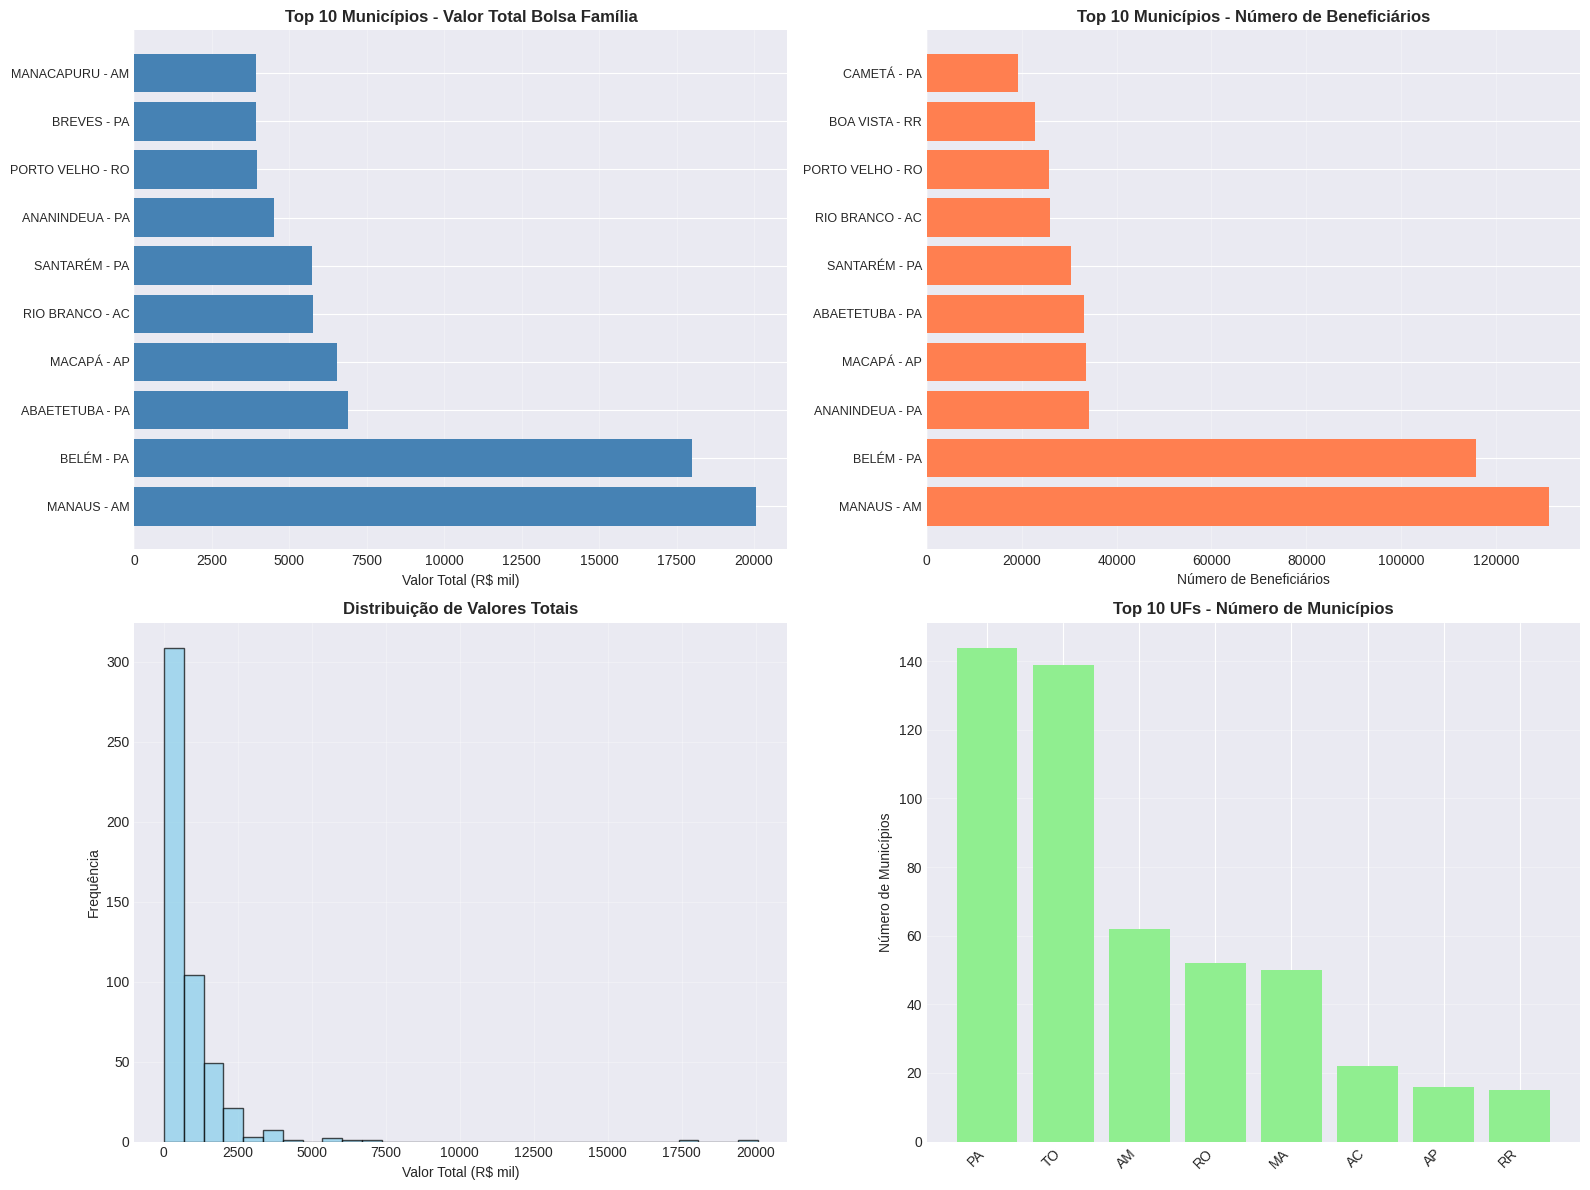

In [7]:
# Visualizações - Bolsa Família
if fato_bolsa_familia is not None and len(fato_bolsa_familia) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Top 10 municípios por valor total
    top10_valor = fato_bolsa_familia.nlargest(10, 'valor_total')
    axes[0, 0].barh(range(len(top10_valor)), top10_valor['valor_total'] / 1000, color='steelblue')
    axes[0, 0].set_yticks(range(len(top10_valor)))
    axes[0, 0].set_yticklabels(top10_valor['nome_municipio'] + ' - ' + top10_valor['uf_sigla'], fontsize=9)
    axes[0, 0].set_xlabel('Valor Total (R$ mil)')
    axes[0, 0].set_title('Top 10 Municípios - Valor Total Bolsa Família', fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='x', alpha=0.3)
    
    # 2. Top 10 municípios por número de beneficiários
    top10_benef = fato_bolsa_familia.nlargest(10, 'quantidade_beneficiarios')
    axes[0, 1].barh(range(len(top10_benef)), top10_benef['quantidade_beneficiarios'], color='coral')
    axes[0, 1].set_yticks(range(len(top10_benef)))
    axes[0, 1].set_yticklabels(top10_benef['nome_municipio'] + ' - ' + top10_benef['uf_sigla'], fontsize=9)
    axes[0, 1].set_xlabel('Número de Beneficiários')
    axes[0, 1].set_title('Top 10 Municípios - Número de Beneficiários', fontsize=12, fontweight='bold')
    axes[0, 1].grid(axis='x', alpha=0.3)
    
    # 3. Distribuição de valores
    if 'valor_total' in fato_bolsa_familia.columns:
        axes[1, 0].hist(fato_bolsa_familia['valor_total'] / 1000, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        axes[1, 0].set_xlabel('Valor Total (R$ mil)')
        axes[1, 0].set_ylabel('Frequência')
        axes[1, 0].set_title('Distribuição de Valores Totais', fontsize=12, fontweight='bold')
        axes[1, 0].grid(alpha=0.3)
    
    # 4. Distribuição por UF (se disponível)
    if 'uf_sigla' in fato_bolsa_familia.columns:
        uf_counts = fato_bolsa_familia['uf_sigla'].value_counts().head(10)
        axes[1, 1].bar(range(len(uf_counts)), uf_counts.values, color='lightgreen')
        axes[1, 1].set_xticks(range(len(uf_counts)))
        axes[1, 1].set_xticklabels(uf_counts.index, rotation=45, ha='right')
        axes[1, 1].set_ylabel('Número de Municípios')
        axes[1, 1].set_title('Top 10 UFs - Número de Municípios', fontsize=12, fontweight='bold')
        axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Dados insuficientes para visualização")

## 5. Análise de BPC (Benefício de Prestação Continuada)

In [8]:
if fato_bpc is not None and len(fato_bpc) > 0:
    print("📊 ESTATÍSTICAS DESCRITIVAS - BPC")
    print("=" * 80)
    
    # Estatísticas básicas
    print("\n💰 Valores Totais:")
    print(f"  Total investido: R$ {fato_bpc['valor'].sum():,.2f}")
    print(f"  Média por município: R$ {fato_bpc['valor'].mean():,.2f}")
    print(f"  Mediana: R$ {fato_bpc['valor'].median():,.2f}")
    print(f"  Máximo: R$ {fato_bpc['valor'].max():,.2f}")
    print(f"  Mínimo: R$ {fato_bpc['valor'].min():,.2f}")
    
    print("\n👥 Beneficiários:")
    print(f"  Total de beneficiários: {fato_bpc['quantidade_beneficiados'].sum():,.0f}")
    print(f"  Média por município: {fato_bpc['quantidade_beneficiados'].mean():,.0f}")
    print(f"  Máximo: {fato_bpc['quantidade_beneficiados'].max():,.0f}")
    
    if 'valor_per_capita' in fato_bpc.columns:
        print("\n💵 Valor Per Capita:")
        print(f"  Média: R$ {fato_bpc['valor_per_capita'].mean():.2f}")
        print(f"  Mediana: R$ {fato_bpc['valor_per_capita'].median():.2f}")
    
    print("\n📅 Período de Referência:")
    if 'data_referencia' in fato_bpc.columns:
        print(f"  Período: {fato_bpc['data_referencia'].min()} a {fato_bpc['data_referencia'].max()}")
    
    print("\n🌎 Distribuição por UF:")
    if 'uf_sigla' in fato_bpc.columns:
        uf_stats = fato_bpc.groupby('uf_sigla').agg({
            'valor': 'sum',
            'quantidade_beneficiados': 'sum',
            'nome_municipio': 'count'
        }).rename(columns={'nome_municipio': 'num_municipios'})
        uf_stats = uf_stats.sort_values('valor', ascending=False)
        print(uf_stats.to_string())
else:
    print("⚠️ Dados de BPC não disponíveis")

📊 ESTATÍSTICAS DESCRITIVAS - BPC

💰 Valores Totais:
  Total investido: R$ 54,142,090.14
  Média por município: R$ 1,082,841.80
  Mediana: R$ 265,464.90
  Máximo: R$ 7,362,414.63
  Mínimo: R$ 32,477.57

👥 Beneficiários:
  Total de beneficiários: 34,672
  Média por município: 693
  Máximo: 4,855

💵 Valor Per Capita:
  Média: R$ 1580.49
  Mediana: R$ 1575.79

📅 Período de Referência:
  Período: 2024-12-01 00:00:00 a 2024-12-01 00:00:00

🌎 Distribuição por UF:
                valor  quantidade_beneficiados  num_municipios
uf_sigla                                                      
SP        54142090.14                    34672              50


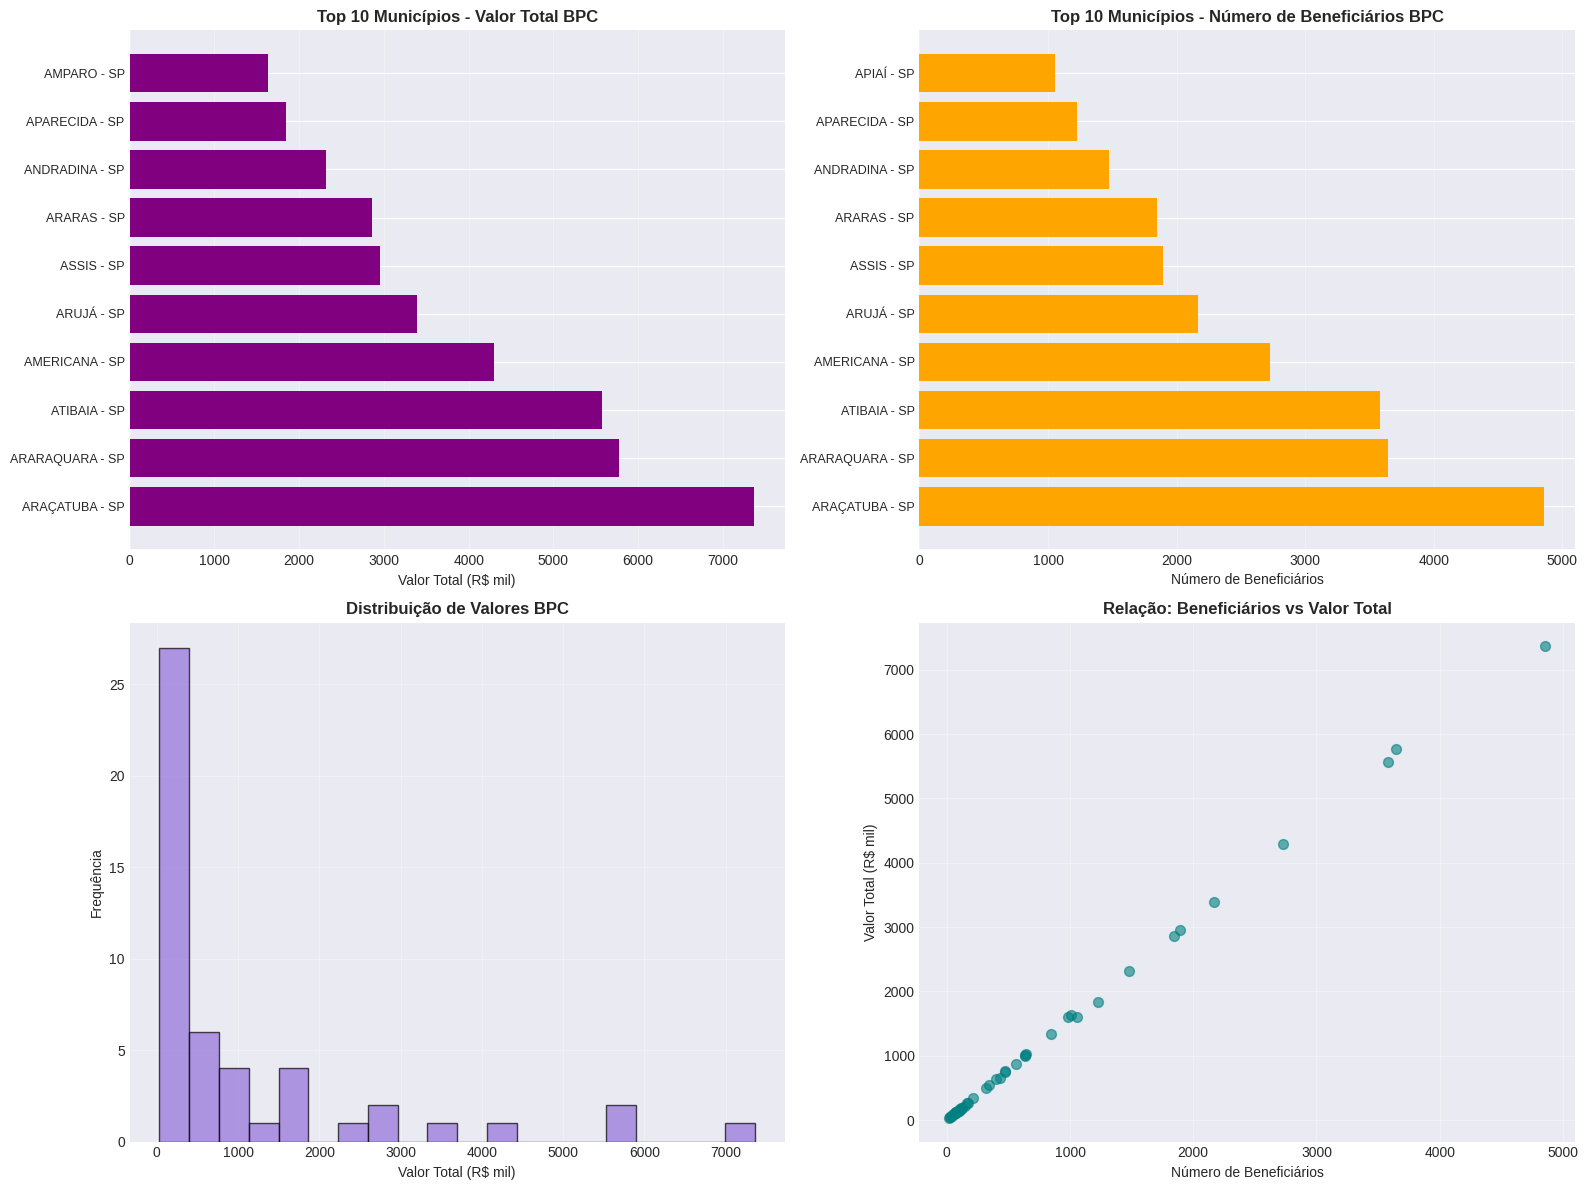

In [9]:
# Visualizações - BPC
if fato_bpc is not None and len(fato_bpc) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Top 10 municípios por valor total
    top10_valor = fato_bpc.nlargest(10, 'valor')
    axes[0, 0].barh(range(len(top10_valor)), top10_valor['valor'] / 1000, color='purple')
    axes[0, 0].set_yticks(range(len(top10_valor)))
    axes[0, 0].set_yticklabels(top10_valor['nome_municipio'] + ' - ' + top10_valor['uf_sigla'], fontsize=9)
    axes[0, 0].set_xlabel('Valor Total (R$ mil)')
    axes[0, 0].set_title('Top 10 Municípios - Valor Total BPC', fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='x', alpha=0.3)
    
    # 2. Top 10 municípios por número de beneficiários
    top10_benef = fato_bpc.nlargest(10, 'quantidade_beneficiados')
    axes[0, 1].barh(range(len(top10_benef)), top10_benef['quantidade_beneficiados'], color='orange')
    axes[0, 1].set_yticks(range(len(top10_benef)))
    axes[0, 1].set_yticklabels(top10_benef['nome_municipio'] + ' - ' + top10_benef['uf_sigla'], fontsize=9)
    axes[0, 1].set_xlabel('Número de Beneficiários')
    axes[0, 1].set_title('Top 10 Municípios - Número de Beneficiários BPC', fontsize=12, fontweight='bold')
    axes[0, 1].grid(axis='x', alpha=0.3)
    
    # 3. Distribuição de valores
    axes[1, 0].hist(fato_bpc['valor'] / 1000, bins=20, color='mediumpurple', edgecolor='black', alpha=0.7)
    axes[1, 0].set_xlabel('Valor Total (R$ mil)')
    axes[1, 0].set_ylabel('Frequência')
    axes[1, 0].set_title('Distribuição de Valores BPC', fontsize=12, fontweight='bold')
    axes[1, 0].grid(alpha=0.3)
    
    # 4. Relação Valor vs Beneficiários
    axes[1, 1].scatter(fato_bpc['quantidade_beneficiados'], fato_bpc['valor'] / 1000, 
                       alpha=0.6, color='teal', s=50)
    axes[1, 1].set_xlabel('Número de Beneficiários')
    axes[1, 1].set_ylabel('Valor Total (R$ mil)')
    axes[1, 1].set_title('Relação: Beneficiários vs Valor Total', fontsize=12, fontweight='bold')
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Dados insuficientes para visualização")

## 6. Análise Comparativa: Bolsa Família vs BPC

📊 COMPARAÇÃO ENTRE PROGRAMAS
     Programa  Total Investido (R$)  Total Beneficiários  Número de Municípios  Valor Médio por Beneficiário (R$)
Bolsa Família          412525161.00              1992622                   500                         207.026301
          BPC           54142090.14                34672                    50                        1561.550823


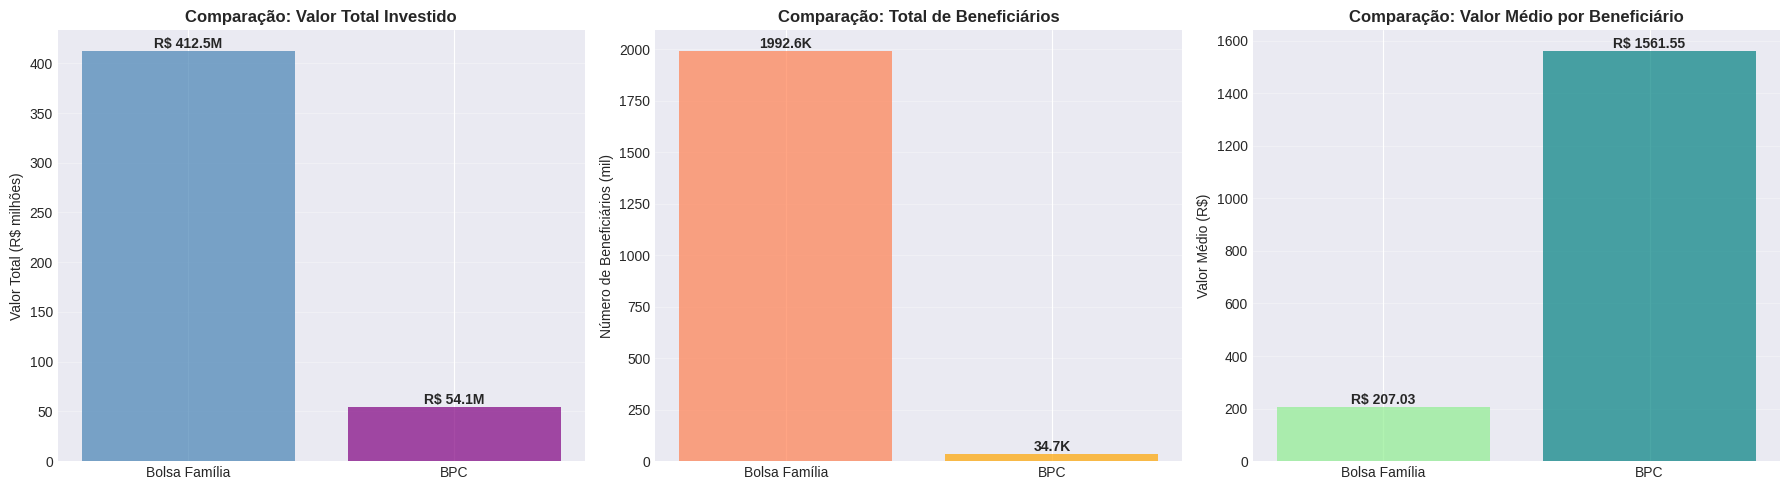

In [10]:
# Comparação entre programas
if fato_bolsa_familia is not None and fato_bpc is not None:
    print("📊 COMPARAÇÃO ENTRE PROGRAMAS")
    print("=" * 80)
    
    comparacao = pd.DataFrame({
        'Programa': ['Bolsa Família', 'BPC'],
        'Total Investido (R$)': [
            fato_bolsa_familia['valor_total'].sum(),
            fato_bpc['valor'].sum()
        ],
        'Total Beneficiários': [
            fato_bolsa_familia['quantidade_beneficiarios'].sum(),
            fato_bpc['quantidade_beneficiados'].sum()
        ],
        'Número de Municípios': [
            len(fato_bolsa_familia),
            len(fato_bpc)
        ],
        'Valor Médio por Beneficiário (R$)': [
            fato_bolsa_familia['valor_total'].sum() / fato_bolsa_familia['quantidade_beneficiarios'].sum(),
            fato_bpc['valor'].sum() / fato_bpc['quantidade_beneficiados'].sum()
        ]
    })
    
    print(comparacao.to_string(index=False))
    
    # Visualização comparativa
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Comparação de valores totais
    axes[0].bar(comparacao['Programa'], comparacao['Total Investido (R$)'] / 1e6, 
                color=['steelblue', 'purple'], alpha=0.7)
    axes[0].set_ylabel('Valor Total (R$ milhões)')
    axes[0].set_title('Comparação: Valor Total Investido', fontsize=12, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    for i, v in enumerate(comparacao['Total Investido (R$)'] / 1e6):
        axes[0].text(i, v, f'R$ {v:.1f}M', ha='center', va='bottom', fontweight='bold')
    
    # 2. Comparação de beneficiários
    axes[1].bar(comparacao['Programa'], comparacao['Total Beneficiários'] / 1000, 
                color=['coral', 'orange'], alpha=0.7)
    axes[1].set_ylabel('Número de Beneficiários (mil)')
    axes[1].set_title('Comparação: Total de Beneficiários', fontsize=12, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    for i, v in enumerate(comparacao['Total Beneficiários'] / 1000):
        axes[1].text(i, v, f'{v:.1f}K', ha='center', va='bottom', fontweight='bold')
    
    # 3. Comparação de valor médio
    axes[2].bar(comparacao['Programa'], comparacao['Valor Médio por Beneficiário (R$)'], 
                color=['lightgreen', 'teal'], alpha=0.7)
    axes[2].set_ylabel('Valor Médio (R$)')
    axes[2].set_title('Comparação: Valor Médio por Beneficiário', fontsize=12, fontweight='bold')
    axes[2].grid(axis='y', alpha=0.3)
    for i, v in enumerate(comparacao['Valor Médio por Beneficiário (R$)']):
        axes[2].text(i, v, f'R$ {v:.2f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Dados insuficientes para comparação")

## 7. Análise por Região/UF

📊 BOLSA FAMÍLIA POR UF
          valor_total  quantidade_beneficiarios  num_municipios  valor_medio_beneficiario
uf_sigla                                                                                 
PA        190150733.0                    960554             144                197.959441
AM         91310101.0                    404493              62                225.739632
MA         43823703.0                    205246              50                213.517939
AC         24353549.0                     90525              22                269.025672
TO         22474279.0                    121212             139                185.412987
AP         17140495.0                     75597              16                226.735122
RO         12355379.0                     83588              52                147.812832
RR         10916922.0                     51407              15                212.362558


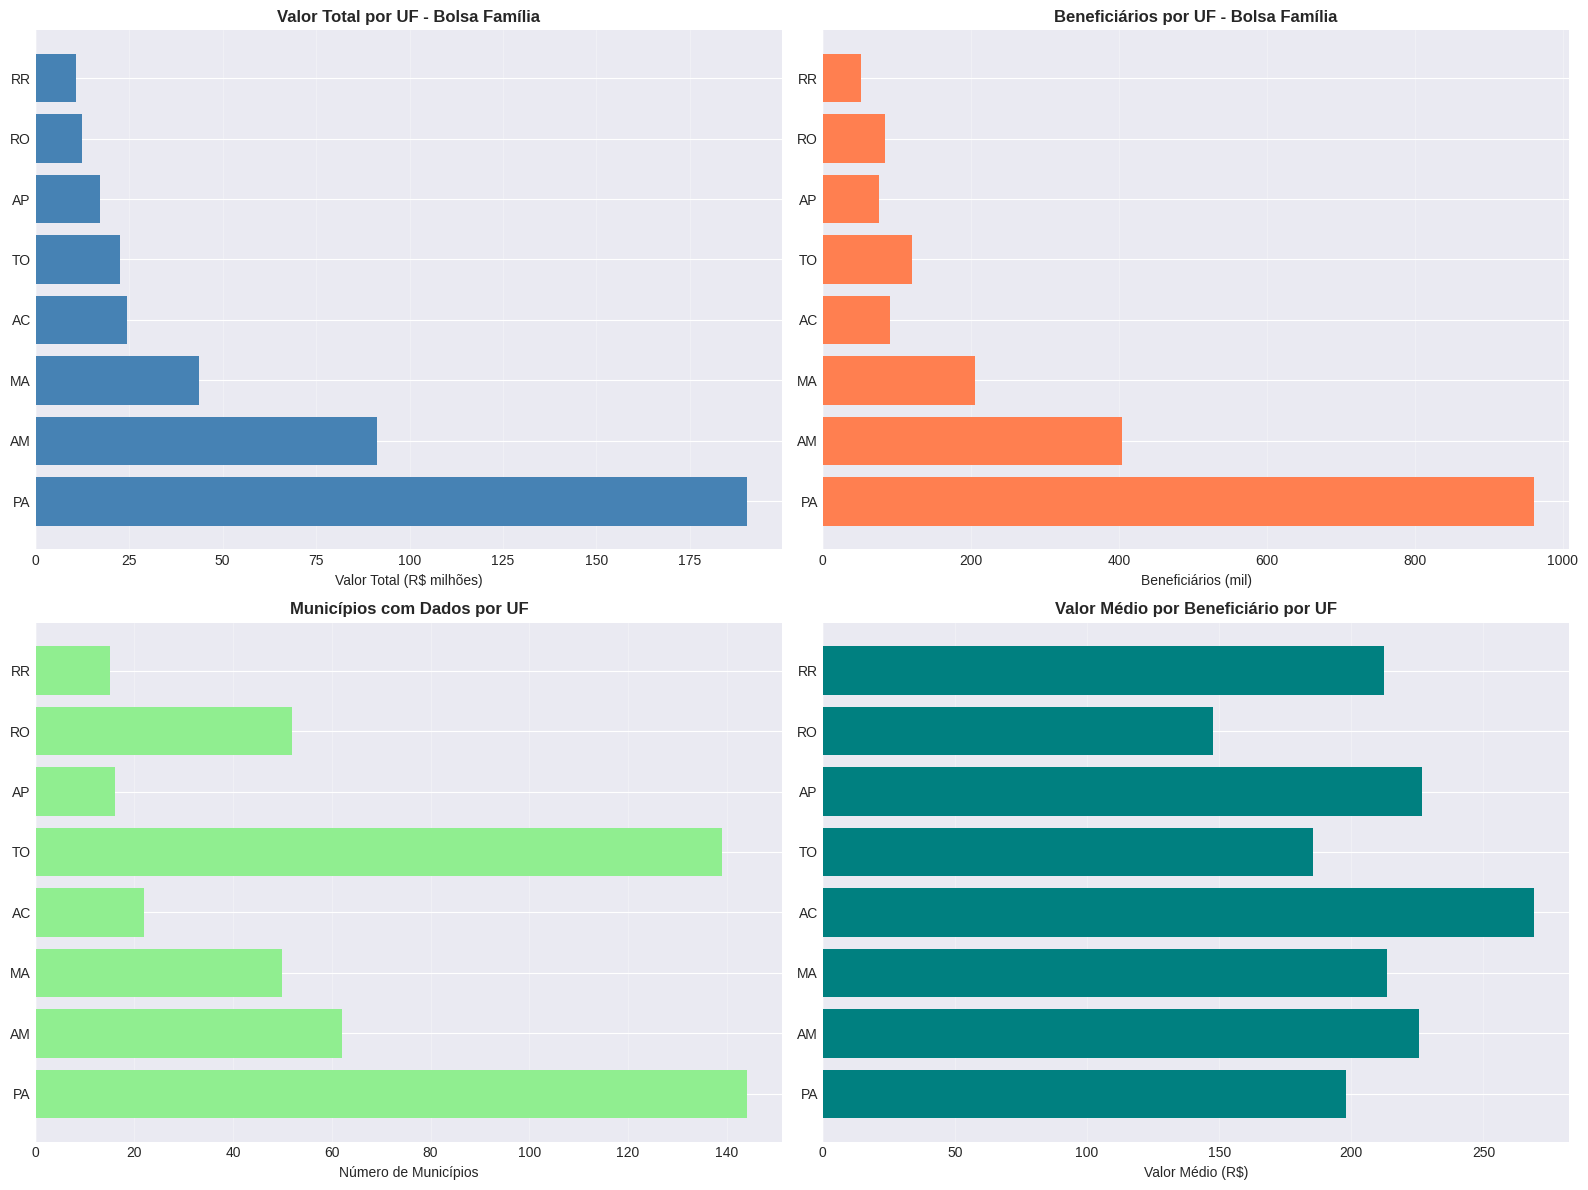

In [11]:
# Análise agregada por UF
if fato_bolsa_familia is not None and 'uf_sigla' in fato_bolsa_familia.columns:
    print("📊 BOLSA FAMÍLIA POR UF")
    print("=" * 80)
    
    bf_por_uf = fato_bolsa_familia.groupby('uf_sigla').agg({
        'valor_total': 'sum',
        'quantidade_beneficiarios': 'sum',
        'nome_municipio': 'count'
    }).rename(columns={'nome_municipio': 'num_municipios'})
    bf_por_uf['valor_medio_beneficiario'] = bf_por_uf['valor_total'] / bf_por_uf['quantidade_beneficiarios']
    bf_por_uf = bf_por_uf.sort_values('valor_total', ascending=False)
    
    print(bf_por_uf.to_string())
    
    # Visualização
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Valor total por UF
    axes[0, 0].barh(range(len(bf_por_uf)), bf_por_uf['valor_total'] / 1e6, color='steelblue')
    axes[0, 0].set_yticks(range(len(bf_por_uf)))
    axes[0, 0].set_yticklabels(bf_por_uf.index)
    axes[0, 0].set_xlabel('Valor Total (R$ milhões)')
    axes[0, 0].set_title('Valor Total por UF - Bolsa Família', fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='x', alpha=0.3)
    
    # 2. Beneficiários por UF
    axes[0, 1].barh(range(len(bf_por_uf)), bf_por_uf['quantidade_beneficiarios'] / 1000, color='coral')
    axes[0, 1].set_yticks(range(len(bf_por_uf)))
    axes[0, 1].set_yticklabels(bf_por_uf.index)
    axes[0, 1].set_xlabel('Beneficiários (mil)')
    axes[0, 1].set_title('Beneficiários por UF - Bolsa Família', fontsize=12, fontweight='bold')
    axes[0, 1].grid(axis='x', alpha=0.3)
    
    # 3. Número de municípios por UF
    axes[1, 0].barh(range(len(bf_por_uf)), bf_por_uf['num_municipios'], color='lightgreen')
    axes[1, 0].set_yticks(range(len(bf_por_uf)))
    axes[1, 0].set_yticklabels(bf_por_uf.index)
    axes[1, 0].set_xlabel('Número de Municípios')
    axes[1, 0].set_title('Municípios com Dados por UF', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='x', alpha=0.3)
    
    # 4. Valor médio por beneficiário por UF
    axes[1, 1].barh(range(len(bf_por_uf)), bf_por_uf['valor_medio_beneficiario'], color='teal')
    axes[1, 1].set_yticks(range(len(bf_por_uf)))
    axes[1, 1].set_yticklabels(bf_por_uf.index)
    axes[1, 1].set_xlabel('Valor Médio (R$)')
    axes[1, 1].set_title('Valor Médio por Beneficiário por UF', fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Dados insuficientes para análise por UF")

## 8. Rankings e Top Municípios

In [12]:
# Rankings
if rankings is not None:
    print("📊 RANKINGS DISPONÍVEIS:")
    print(rankings.head(20).to_string(index=False))
else:
    # Criar rankings manualmente
    print("📊 TOP 20 MUNICÍPIOS - BOLSA FAMÍLIA")
    print("=" * 80)
    
    if fato_bolsa_familia is not None:
        top20_bf = fato_bolsa_familia.nlargest(20, 'valor_total')[
            ['nome_municipio', 'uf_sigla', 'valor_total', 'quantidade_beneficiarios']
        ].copy()
        top20_bf['valor_total_mil'] = top20_bf['valor_total'] / 1000
        top20_bf = top20_bf[['nome_municipio', 'uf_sigla', 'valor_total_mil', 'quantidade_beneficiarios']]
        top20_bf.columns = ['Município', 'UF', 'Valor Total (R$ mil)', 'Beneficiários']
        print(top20_bf.to_string(index=False))
        
        print("\n📊 TOP 20 MUNICÍPIOS - BPC")
        print("=" * 80)
        
        if fato_bpc is not None:
            top20_bpc = fato_bpc.nlargest(20, 'valor')[
                ['nome_municipio', 'uf_sigla', 'valor', 'quantidade_beneficiados']
            ].copy()
            top20_bpc['valor_mil'] = top20_bpc['valor'] / 1000
            top20_bpc = top20_bpc[['nome_municipio', 'uf_sigla', 'valor_mil', 'quantidade_beneficiados']]
            top20_bpc.columns = ['Município', 'UF', 'Valor Total (R$ mil)', 'Beneficiários']
            print(top20_bpc.to_string(index=False))

📊 RANKINGS DISPONÍVEIS:
tipo_ranking  posicao           municipio uf_sigla      valor  quantidade_beneficiados         data_processamento versao_dados
 valor_total        1           ARAÇATUBA       SP 7362414.63                     4855 2025-11-15 20:48:06.528905          1.0
 valor_total        2          ARARAQUARA       SP 5769641.14                     3643 2025-11-15 20:48:06.528905          1.0
 valor_total        3             ATIBAIA       SP 5569057.35                     3585 2025-11-15 20:48:06.528905          1.0
 valor_total        4           AMERICANA       SP 4298244.69                     2730 2025-11-15 20:48:06.528905          1.0
 valor_total        5               ARUJÁ       SP 3388887.55                     2166 2025-11-15 20:48:06.528905          1.0
 valor_total        6               ASSIS       SP 2951173.18                     1891 2025-11-15 20:48:06.528905          1.0
 valor_total        7              ARARAS       SP 2860790.57                     1844 

## 9. Análise de População e Beneficiários

📊 ANÁLISE: POPULAÇÃO vs BENEFICIÁRIOS

📈 Correlações:
                          populacao  quantidade_beneficiarios  percentual_beneficiarios
populacao                  1.000000                  0.931568                 -0.098190
quantidade_beneficiarios   0.931568                  1.000000                 -0.123374
percentual_beneficiarios  -0.098190                 -0.123374                  1.000000


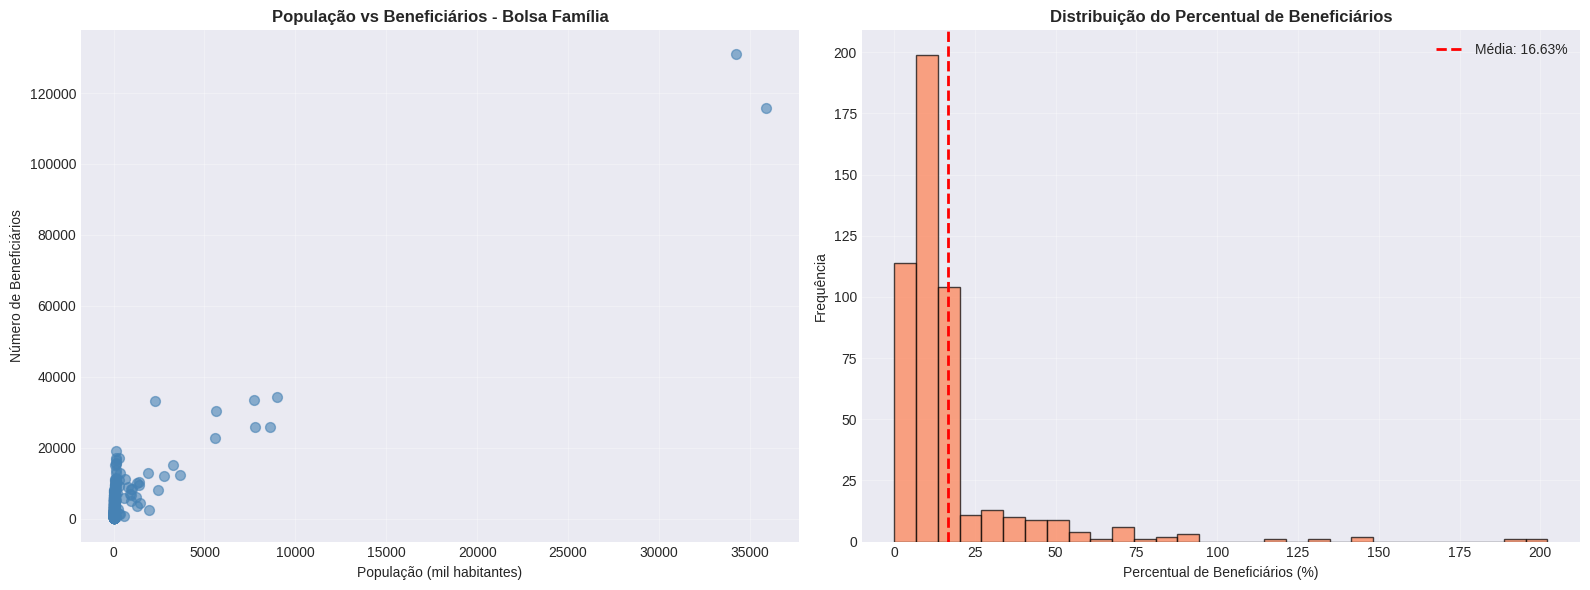


✅ 492 municípios com dados de população disponíveis


In [13]:
# Análise de relação população vs beneficiários
if fato_bolsa_familia is not None and 'populacao' in fato_bolsa_familia.columns:
    # Filtrar apenas municípios com população disponível
    bf_com_pop = fato_bolsa_familia[fato_bolsa_familia['populacao'].notna()].copy()
    
    if len(bf_com_pop) > 0:
        print("📊 ANÁLISE: POPULAÇÃO vs BENEFICIÁRIOS")
        print("=" * 80)
        
        # Calcular correlação
        if 'percentual_beneficiarios' in bf_com_pop.columns:
            corr = bf_com_pop[['populacao', 'quantidade_beneficiarios', 'percentual_beneficiarios']].corr()
            print("\n📈 Correlações:")
            print(corr.to_string())
        
        # Visualização
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # 1. População vs Beneficiários
        axes[0].scatter(bf_com_pop['populacao'] / 1000, bf_com_pop['quantidade_beneficiarios'], 
                       alpha=0.6, color='steelblue', s=50)
        axes[0].set_xlabel('População (mil habitantes)')
        axes[0].set_ylabel('Número de Beneficiários')
        axes[0].set_title('População vs Beneficiários - Bolsa Família', fontsize=12, fontweight='bold')
        axes[0].grid(alpha=0.3)
        
        # 2. Percentual de beneficiários
        if 'percentual_beneficiarios' in bf_com_pop.columns:
            axes[1].hist(bf_com_pop['percentual_beneficiarios'], bins=30, color='coral', 
                        edgecolor='black', alpha=0.7)
            axes[1].set_xlabel('Percentual de Beneficiários (%)')
            axes[1].set_ylabel('Frequência')
            axes[1].set_title('Distribuição do Percentual de Beneficiários', fontsize=12, fontweight='bold')
            axes[1].grid(alpha=0.3)
            axes[1].axvline(bf_com_pop['percentual_beneficiarios'].mean(), 
                          color='red', linestyle='--', linewidth=2, label=f'Média: {bf_com_pop["percentual_beneficiarios"].mean():.2f}%')
            axes[1].legend()
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n✅ {len(bf_com_pop)} municípios com dados de população disponíveis")
    else:
        print("⚠️ Nenhum município com dados de população disponível")
else:
    print("⚠️ Dados de população não disponíveis para análise")

## 10. Exportar Dados para Análise Externa

In [14]:
# Exportar dados principais para CSV (opcional)
exportar = False  # Mude para True se quiser exportar

if exportar:
    if fato_bolsa_familia is not None:
        fato_bolsa_familia.to_csv('bolsa_familia_analise.csv', index=False)
        print("✅ Bolsa Família exportado para CSV")
    
    if fato_bpc is not None:
        fato_bpc.to_csv('bpc_analise.csv', index=False)
        print("✅ BPC exportado para CSV")
    
    if municipios_ouro is not None:
        municipios_ouro.to_csv('municipios_enriquecidos.csv', index=False)
        print("✅ Municípios exportados para CSV")
    
    print("\n✅ Exportação concluída!")
else:
    print("💡 Para exportar os dados, altere a variável 'exportar' para True")

💡 Para exportar os dados, altere a variável 'exportar' para True


## 11. Informações sobre os Dados

### Fonte dos Dados:
- **Portal da Transparência**: https://api.portaldatransparencia.gov.br
- **IBGE**: https://servicodados.ibge.gov.br

### Períodos dos Dados:
- **Bolsa Família**: Dados de outubro/2021 (500 municípios)
- **BPC**: Dados de dezembro/2024 (50 municípios de SP)
- **População**: Dados de 2010 (982 municípios únicos)

### Observações:
- Os dados foram coletados em tempo real das APIs governamentais
- Alguns municípios podem não ter dados disponíveis para todos os períodos
- A população por município foi agregada para tratar duplicatas da API do IBGE

In [ ]:
pode 